# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [5]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #additional flag to keep kernel from crashing

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [6]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Using TensorFlow backend.


X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


an example of a data point with label 4


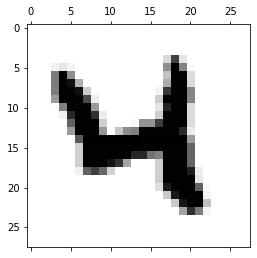

an example of a data point with label 4 before to_categorical ...
... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [7]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

print('an example of a data point with label', Y_train[20], 'before to_categorical ...')
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [9]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [10]:
# training parameters
batch_size = 32
epochs = 10

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 15s - loss: 0.2833 - acc: 0.9157 - val_loss: 0.1148 - val_acc: 0.9646
Epoch 2/10
 - 15s - loss: 0.1202 - acc: 0.9661 - val_loss: 0.0835 - val_acc: 0.9725
Epoch 3/10
 - 15s - loss: 0.0863 - acc: 0.9744 - val_loss: 0.0764 - val_acc: 0.9769
Epoch 4/10
 - 15s - loss: 0.0681 - acc: 0.9799 - val_loss: 0.0773 - val_acc: 0.9777
Epoch 5/10
 - 15s - loss: 0.0561 - acc: 0.9830 - val_loss: 0.0827 - val_acc: 0.9769
Epoch 6/10
 - 16s - loss: 0.0460 - acc: 0.9864 - val_loss: 0.0821 - val_acc: 0.9767
Epoch 7/10
 - 16s - loss: 0.0398 - acc: 0.9878 - val_loss: 0.0799 - val_acc: 0.9783
Epoch 8/10
 - 16s - loss: 0.0358 - acc: 0.9890 - val_loss: 0.0809 - val_acc: 0.9800
Epoch 9/10
 - 16s - loss: 0.0311 - acc: 0.9899 - val_loss: 0.0799 - val_acc: 0.9788
Epoch 10/10
 - 15s - loss: 0.0280 - acc: 0.9912 - val_loss: 0.0812 - val_acc: 0.9820


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

10000/10000 [==============================] - 1s 51us/step

Test loss: 0.08118309097185462
Test accuracy: 0.9819999933242798


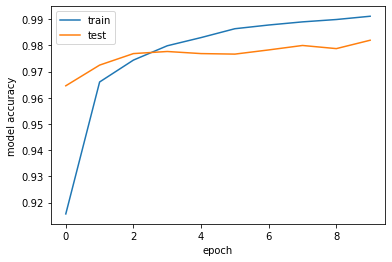

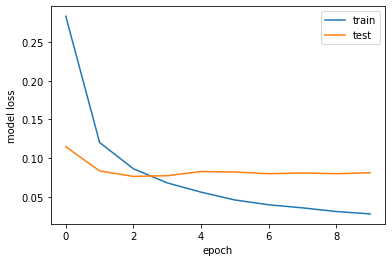

In [11]:
filename = "12_1/_.txt"

epoch_ = np.arange(1,epochs+1)

# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#with open(filename, 'w') as fh:
 #   fh.writelines(map("{}\t{}\t{}\n".format, epoch_, history.history['loss'],history.history['val_loss']))
    
with open("12_1/score_compare.txt",'a') as f:
    f.write('SGD \t'+str(score[0])+'\t'+str(score[1])+'\n')

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

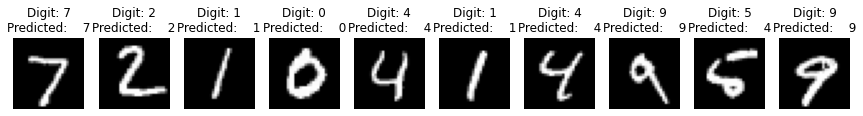

In [12]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

By keeping fixed all the other parameters, try to use at least two other optimizers, different from SGD. <span style="color:red">Watch to accuracy and loss for training and validation data and comment on the performances</span>.

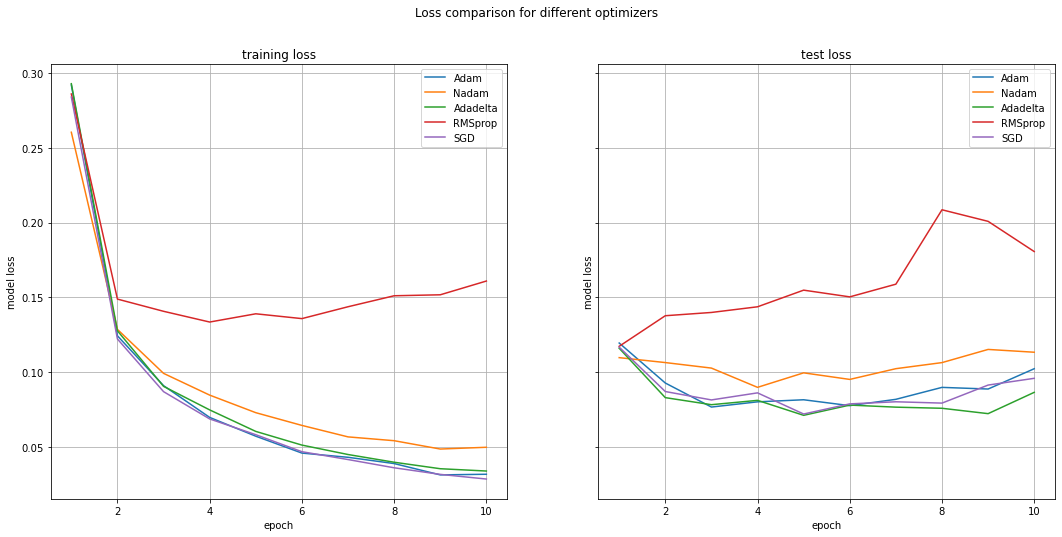

In [13]:
opt_ = ['Adam', 'Nadam', 'Adadelta', 'RMSprop','SGD']

fig, axs = plt.subplots (1, 2, figsize = [18, 8], sharey=True)
fig.suptitle('Loss comparison for different optimizers')

for opt in opt_:
    epoch, loss, val_loss = np.loadtxt("12_1/"+opt+".txt", usecols=(0,1,2), unpack=True)
    axs[0].plot(epoch, loss, label = opt)
    axs[1].plot(epoch, val_loss, label = opt)

axs[0].set_xlabel('epoch')
axs[0].set_ylabel('model loss')
axs[0].set_title('training loss')
axs[0].grid(True)
axs[0].legend(loc='best')

axs[1].set_xlabel('epoch')
axs[1].set_ylabel('model loss')
axs[1].set_title('test loss')
axs[1].grid(True)
axs[1].legend(loc='best')

plt.show()

The graphs compare how well each optimisation function works in this DNN for categorising images of digits. On the left we have the training loss, given by confronting the training data with its labels while on the left we have the loss obtained by the validation data. 

Obviously, we'd expect for loss to decrease with epochs, as the parameters are more and more adjusted to recognise the data set. Apart form the RMSProp example, we see that training loss tends to $0$: we'd expect that, by increasing the training epochs, this value would decrease even more. On the other hand, test loss tends to remain constant throughout all training. I'd explain this by saying that the validatoin data does not influence the classification parameters: while the network "gets used" to the training data, getting more and more precise in its classification, if the validation loss remains constant implies that the neural network tends to overfit the traininng data, without ever improving for unknown situations. In order to improve the network, instead of changing too much the network's architecture one could add another dropout layer, so that only reliable connections and classification schemes are kept.
We notice that even in this case RMSProp underperforms compared to the others.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [14]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. 

To build this network I was inspired by the excellent example made by Adam Harley: two convolution layers, separated by pooling layers to reduce the input size, before flattening the layer and adding two dense layers and a final *softmax* categorisation. The main changes I attempted were the inclusion of dropout layers, between the two convolutional and between the two dense layers, given the relevance they had shown in the previous example; other minor changes include some of the layer sizes and the activation function, using what I learned back then with the DNNs.

I even made attempts with larger and deeper networks; however the results did not improve as expected, almost not at all, so to save some training time I went back to the simplest architecture that would guarantee results with my image dataset.

In [15]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(6, kernel_size=(2, 2),
                     activation='tanh',
                     input_shape=input_shape, strides =2))
      
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid"))

    model.add(Conv2D(16, kernel_size=(5, 5),activation='tanh',input_shape=input_shape))
    model.add(Dropout(0.5))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid"))
    
    #model.add(Conv2D(32, kernel_size=(5, 5),activation='tanh',input_shape=input_shape))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding="valid"))
    model.add(Flatten())
    
    #model.add(Dense(320, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))

    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='sgd',
                  metrics=['acc'])
    return model

Train your DCNN and evaluate its performance proceeding exactly as before:

In [16]:
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=2)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 72s - loss: 0.6640 - acc: 0.7854 - val_loss: 0.2623 - val_acc: 0.9300
Epoch 2/10
 - 71s - loss: 0.2663 - acc: 0.9169 - val_loss: 0.1733 - val_acc: 0.9512
Epoch 3/10
 - 70s - loss: 0.2029 - acc: 0.9368 - val_loss: 0.1440 - val_acc: 0.9580
Epoch 4/10
 - 70s - loss: 0.1733 - acc: 0.9451 - val_loss: 0.1180 - val_acc: 0.9644
Epoch 5/10
 - 72s - loss: 0.1474 - acc: 0.9535 - val_loss: 0.1052 - val_acc: 0.9689
Epoch 6/10
 - 73s - loss: 0.1381 - acc: 0.9564 - val_loss: 0.0992 - val_acc: 0.9694
Epoch 7/10
 - 73s - loss: 0.1289 - acc: 0.9604 - val_loss: 0.0969 - val_acc: 0.9688
Epoch 8/10
 - 71s - loss: 0.1200 - acc: 0.9634 - val_loss: 0.0829 - val_acc: 0.9731
Epoch 9/10
 - 70s - loss: 0.1134 - acc: 0.9650 - val_loss: 0.0857 - val_acc: 0.9722
Epoch 10/10
 - 70s - loss: 0.1059 - acc: 0.9671 - val_loss: 0.0741 - val_acc: 0.9757

Test loss: 0.07411458531897515
Test accuracy: 0.9757000207901001


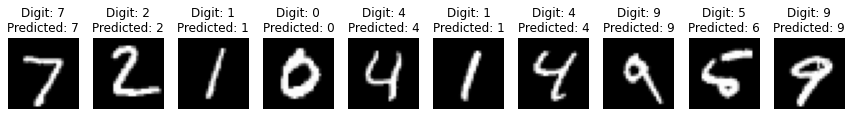

In [17]:
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

As we can see, the CNN works quite well with the already available dataset, with results comparable to the previous DNN.

### Exercise 12.3

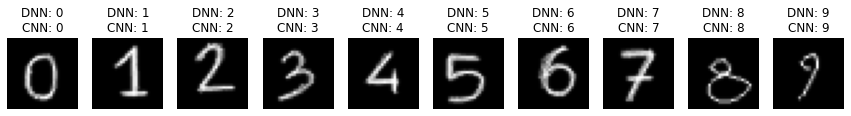

In [21]:
from PIL import Image
plt.figure(figsize=(15, 15)) 


for k in range(10):
    digit_filename = "./digits/"+str(k)+".png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))

    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    
    ax = plt.subplot(2, 10, k+1)    
    plt.imshow(data, cmap='gray')
    
    data = data.reshape(1,xdim*ydim)
    pred_d = model_DNN.predict(data) # compares result with that of DNN
    
    
    # reshape data, depending on Keras backend, in order to be evaluated by CNN
    if keras.backend.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    pred_c = model_CNN.predict(data) # compares result with that of DNN
    
    plt.title("DNN: {}\nCNN: {}".format(np.argmax(pred_d), np.argmax(pred_d)))
    plt.axis('off') 
    
plt.show()

Here we test the efficiency of the CNN with a dataset I made myself, with my golden little hands. I tried to make digits as standard as possible, even stressing the boundaries between image and background. The results in this case are optimal, perfectly equivalent to the dense architecture from before.

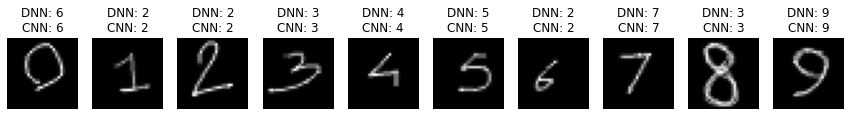

In [23]:
plt.figure(figsize=(15, 15)) 


for k in range(10):
    digit_filename = "./digits/"+str(k)+"b.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))


    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    
    ax = plt.subplot(2, 10, k + 1)    
    plt.imshow(data, cmap='gray')
    
    data = data.reshape(1,xdim*ydim)
    pred_d = model_DNN.predict(data) # compares result with that of DNN
    
    
    # reshape data, depending on Keras backend, in order to be evaluated by CNN
    if keras.backend.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    pred_c = model_CNN.predict(data) # compares result with that of DNN
    
    plt.title("DNN: {}\nCNN: {}".format(np.argmax(pred_d), np.argmax(pred_d)))
    plt.axis('off')
    
plt.show()

This is the point where I thought I knew better than everybody else and **had** to try my luck, by creating a new dataset of not-so-good digits, mainly because they seem paler than the previous examples. We see now that the Neural Network does not work as well as it was intended, not recognising some of the more difficult digits. It still gives the same results obtained with the DNN.

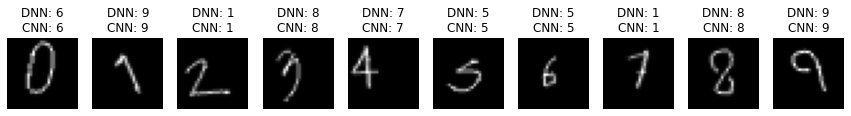

In [13]:
plt.figure(figsize=(15, 15)) 


for k in range(10):
    digit_filename = "./digits/"+str(k)+"bb.png"
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))


    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    

    ax = plt.subplot(2, 10, k + 1)    
    plt.imshow(data, cmap='gray')
    
    data = data.reshape(1,xdim*ydim)
    pred_d = model_DNN.predict(data) # compares result with that of DNN
    
    
    # reshape data, depending on Keras backend, in order to be evaluated by CNN
    if keras.backend.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    pred_c = model_CNN.predict(data) # compares result with that of DNN
    
    plt.title("DNN: {}\nCNN: {}".format(np.argmax(pred_d), np.argmax(pred_d)))
    plt.axis('off')
    
plt.show()

Not happy, I tried once again to see if there were any differences with the DNN, so I created *another* dataset of pale, misshaped digits to prove that, somewhere the two networks might differ. I was disappointed once again, as the number of errors increased while the results remained consistent between the two architectures. The main answer I would give to this issue is that these two last dataset are too different to the training data on which both were trained. Both networks are not able to recognise these digits because they do not have the (implicit) requirements they learned to recognise in order to classificate the numbers. Since even by expanding the network structure no improvements are made, the only solution would be to include different data in the training sample, in order to teach these networks to recognise also other aspects of digits they did not consider until now.